#N2 Method

This simplified nonlinear procedure for the estimation of the seismic response of structures uses capacity curves and inelastic spectra. This method has been developed to be combined with code-bsed response spectra, but is is also possible to employ it to assess structural response against ground motion records. It also has the distinct aspect of assuming an elasto-perfectly plastic force-displacement relationship in the construction of the bilinear curve.

In the following figure, a fragility model developed using this method is presented: 
<img src="../../../../../figures/fragility_example.png" height="200" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the folder containing this input using the parameter input_folder.

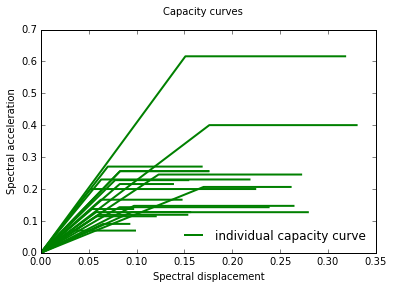

{'Say': [0.143, 0.14723, 0.13728, 0.11454, 0.22996, 0.0697, 0.27038, 0.40041, 0.16652, 0.11926, 0.09065, 0.61627, 0.24548, 0.19998, 0.21566, 0.12763, 0.20654, 0.22784, 0.12734, 0.25609], 'periods': [1.52, 1.63, 1.25, 1.43, 1.05, 1.34, 1.02, 1.33, 1.23, 1.43, 1.7, 0.99, 1.42, 1.02, 1.24, 1.35, 1.82, 1.17, 1.73, 1.14], 'Sa': [[0.0, 0.143, 0.143], [0.0, 0.14723, 0.14723], [0.0, 0.13728, 0.13728], [0.0, 0.11454, 0.11454], [0.0, 0.22996, 0.22996], [0.0, 0.0697, 0.0697], [0.0, 0.27038, 0.27038], [0.0, 0.40041, 0.40041], [0.0, 0.16652, 0.16652], [0.0, 0.11926, 0.11926], [0.0, 0.09065, 0.09065], [0.0, 0.61627, 0.61627], [0.0, 0.24548, 0.24548], [0.0, 0.19998, 0.19998], [0.0, 0.21566, 0.21566], [0.0, 0.12763, 0.12763], [0.0, 0.20654, 0.20654], [0.0, 0.22784, 0.22784], [0.0, 0.12734, 0.12734], [0.0, 0.25609, 0.25609]], 'Sd': [[0.0, 0.0821, 0.238], [0.0, 0.0972, 0.264], [0.0, 0.0533, 0.0964], [0.0, 0.0582, 0.12], [0.0, 0.063, 0.218], [0.0, 0.0311, 0.0983], [0.0, 0.0699, 0.168], [0.0, 0.176, 0.33]

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '/Users/vitorsilva/Documents/GEM/git/gem/rmtk_data/all_curves.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
print capacity_curves

## Load ground motion records

In [2]:
gmrs_folder = '/Users/vitorsilva/Documents/GEM/git/gem/rmtk_data/accelerograms'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2
#utils.plot_response_spectra(gmrs,minT,maxT)

##Calculate fragility function


{'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse'], 'cov': [0.05, 0.05, 0.05, 0.05], 'type_criteria': 'capacity curve dependent', 'type_damage_state': ['fraction Sdy', 'Sdy', 'mean Sdy Sdu', 'Sdu'], 'distribution': ['normal', 'normal', 'normal', 'normal'], 'mean': [0.5, '0.05', '0.05', '0.05']}
5%
0
normal
normal
normal
normal
10%
1
normal
normal
normal
normal
15%
2
normal
normal
normal
normal
20%
3
normal
normal
normal
normal
25%
4
normal
normal
normal
normal
30%
5
normal
normal
normal
normal
35%
6
normal
normal
normal
normal
40%
7
normal
normal
normal
normal
45%
8
normal
normal
normal
normal
50%
9
normal
normal
normal
normal
55%
10
normal
normal
normal
normal
60%
11
normal
normal
normal
normal
65%
12
normal
normal
normal
normal
70%
13
normal
normal
normal
normal
75%
14
normal
normal
normal
normal
80%
15
normal
normal
normal
normal
85%
16
normal
normal
normal
normal
90%
17
normal
normal
normal
normal
95%
18
normal
normal
normal
normal
100%
19
normal
normal
normal
normal

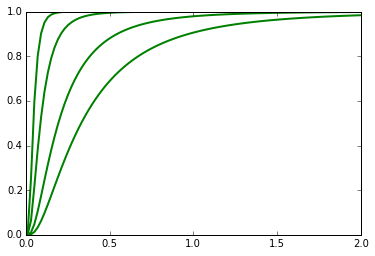

In [3]:
import N2Method

damage_model = utils.read_damage_model('/Users/vitorsilva/Documents/GEM/git/gem/rmtk_data/damage_model.csv')
print damage_model
damping = 0.05
T = 2.0
PDM, Sds = N2Method.calculate_fragility(capacity_curves,gmrs,damage_model,damping)
fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model)
utils.plot_fragility_model(fragility_model,0.01,2)